In [16]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [3]:
pwd

'C:\\Users\\Aaron\\Documents\\ML_Udacity\\PPP'

In [124]:
with open(r'C:\Users\Aaron\Documents\ML_Udacity\PPP\api_key.yaml') as f:
    key = yaml.safe_load(f)

In [131]:
mt150 = pd.read_csv('C:/Users/Aaron/Documents/ML_Udacity/PPP/All Data by State/All Data by State/150k plus/PPP Data 150k plus.csv')

In [112]:
print("Data Set: PPP More than $150k \nRows: {}\nCols: {}".format(mt150.shape[0], mt150.shape[1]))

Data Set: PPP More than $150k 
Rows: 661218
Cols: 16


In [ ]:
# mt150.head()

In [132]:
# Creates a new column 'NAICSCode_int' which converts 'NAICSCode' into integer.

mt150['NAICSCode_int'] = mt150['NAICSCode'].fillna('0').astype('int')
mt150['Zip'] = mt150['Zip'].fillna(' ').astype(str)
for col in ['Address', 'City', 'State']:
    mt150[col] = mt150[col].fillna('NA').astype('str')

In [20]:
def get_naics(naicscode):
    '''Requests NAICS api to retrieve code title.'''
    
    page = requests.get("http://api.naics.us/v0/q?year=2012&code={}".format(naicscode))
    naicspage = json.loads(page.content)
    try:
        title = naicspage['title']
    except:
        title = 'NAICS Not Found'
    return title

In [ ]:
## get_naics(mt150['NAICSCode_int'][0])

In [ ]:
# Retrieve all NAICS Titles

# mt150['NAICS_title'] = mt150['NAICSCode_int'].apply(lambda x: get_naics(x))

In [21]:
%%time
top50try = mt150['NAICSCode_int'][:50].apply(lambda x: get_naics(x))

Wall time: 5.36 s


In [22]:
print('Would take {} hours to retrieve all NAICS titles.'.format(((mt150.shape[0] / 50) * 5.29) /3600))

Would take 19.432462333333334 hours to retrieve all NAICS titles.


In [ ]:
# mt150.groupby('NAICSCode_int')['BusinessName'].nunique().sort_values(ascending=False)[:20]

In [23]:
# Create new frame with only unique NAICS codes.

uqNAICSCodes = pd.DataFrame(mt150['NAICSCode_int'].unique(), columns=['NAICSCode_int'])

In [24]:
%%time
# Retrieve titles for Unique NAICS codes.

uqNAICSCodes['titles'] = uqNAICSCodes['NAICSCode_int'].apply(lambda x: get_naics(x))

Wall time: 2min 34s


In [25]:
# Merge Unique titles into main frame. 

mt150 = mt150.merge(uqNAICSCodes, on='NAICSCode_int')

In [26]:
# Split LoanRange into two: LoanCategory and LoanRange

mt150[['LoanCategory', 'LoanRange']] = mt150['LoanRange'].str.split(' ', 1, expand=True)

In [ ]:
#pd.DataFrame(mt150.groupby('titles')[['BusinessName', 'LoanCategory']].count().sort_values(by='BusinessName', ascending=False))[:25]

In [27]:
barplot_frame = pd.DataFrame(mt150.titles.value_counts().sort_values(ascending=False)[:6])

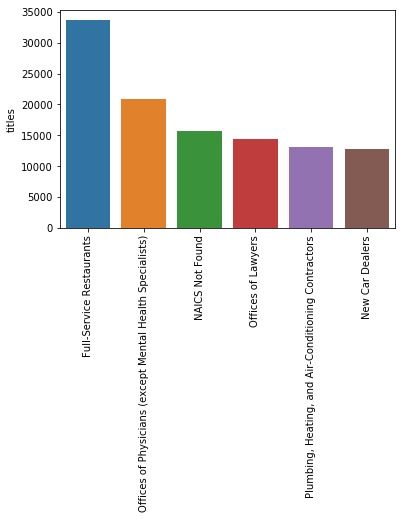

In [28]:
plot = sns.barplot(y = barplot_frame["titles"], x = barplot_frame.index)
plot.set_xticklabels(labels = barplot_frame.index, rotation=90)
plt.show()

In [30]:
# catplot_frame.LoanRange.unique()

In [31]:
catplot_frame = pd.DataFrame(mt150.groupby(['titles', 'LoanRange']).agg({'BusinessName': 'count'}))
catplot_frame = catplot_frame.reset_index()
catplot_frame.shape

(4765, 3)

In [32]:
catplot_frame = catplot_frame.loc[catplot_frame['titles'].isin(barplot_frame.index)]

In [33]:
catplot_frame.head()

,titles,LoanRange,BusinessName
1655,Full-Service Restaurants,$1-2 million,1004
1656,Full-Service Restaurants,"$150,000-350,000",24631
1657,Full-Service Restaurants,$2-5 million,440
1658,Full-Service Restaurants,"$350,000-1 million",7351
1659,Full-Service Restaurants,$5-10 million,182


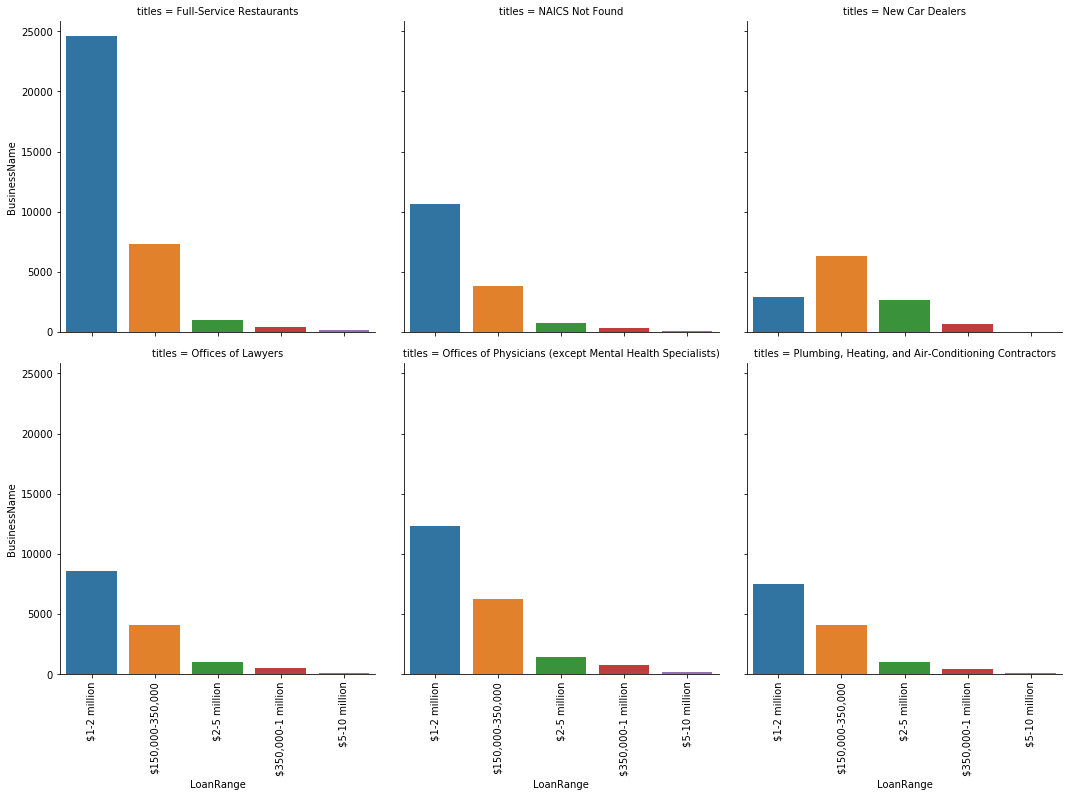

In [34]:
plot = sns.catplot(kind='bar', x = "LoanRange", y = "BusinessName", col = 'titles', data=catplot_frame, 
                   col_wrap=3, order=['$150,000-350,000', '$350,000-1 million', '$1-2 million', '$2-5 million','$5-10 million'])
plot.set_xticklabels(labels = catplot_frame["LoanRange"], rotation=90)
plt.show()

In [141]:
nola = mt150.loc[mt150['City'] == 'NEW ORLEANS'].copy()

In [142]:
nola['full_address'] = nola[['Address', 'City', 'State', 'Zip']].agg(' '.join, axis=1)

In [143]:
# nola['lat'] = pd.Series()
# nola['lng'] = pd.Series()
nola['request'] = pd.Series()

C:\Users\Aaron\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [163]:
nola.head()

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,NAICSCode_int,full_address,request
264508,a $5-10 million,ADAMS AND REESE LLP,701 Poydras St Ste 4500,NEW ORLEANS,LA,70139.0,541110.0,Limited Liability Partnership,Unanswered,Unanswered,Unanswered,NaN,458.0,04/13/2020,Regions Bank,LA - 02,541110,701 Poydras St Ste 4500 NEW ORLEANS LA 70139.0,NaN
264512,a $5-10 million,AUTO-CHLOR SERVICES LLC,500 DAKIN ST,NEW ORLEANS,LA,70121.0,325611.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,370.0,04/09/2020,IBERIABANK,LA - 01,325611,500 DAKIN ST NEW ORLEANS LA 70121.0,NaN
264518,a $5-10 million,COLLEGIATE ACADEMIES,2625 THALIA ST,NEW ORLEANS,LA,70113.0,611110.0,Non-Profit Organization,Unanswered,Unanswered,Unanswered,Y,445.0,04/10/2020,Liberty Bank and Trust Company,LA - 02,611110,2625 THALIA ST NEW ORLEANS LA 70113.0,NaN
264525,a $5-10 million,DONOVAN MARINE INC,6316 HUMPHREYS STREET,NEW ORLEANS,LA,70123.0,423860.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,442.0,04/10/2020,IBERIABANK,LA - 01,423860,6316 HUMPHREYS STREET NEW ORLEANS LA 70123.0,NaN
264526,a $5-10 million,DOYLE LAND SERVICES INC,400 POYDRAS STREET SUITE 1600,NEW ORLEANS,LA,70130.0,541199.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,175.0,04/08/2020,IBERIABANK,LA - 02,541199,400 POYDRAS STREET SUITE 1600 NEW ORLEANS LA 7...,NaN


In [245]:
nola.shape

(1234, 19)

In [157]:
def geocode(address):
    '''Takes address and outputs geocoordinates for mapping.
        Intended for output to create new column in original df'''
    
    url = 'https://maps.googleapis.com/maps/api/geocode/json'
    params = {'address':address, 'key':key}
    r = requests.get(url, params=params).json()['results']
    #loc = r[0]['geometry']['location']
    return r[0]

In [139]:
geocode(nola.iloc[0]['full_address'])

[{'address_components': [{'long_name': '4500',
    'short_name': '4500',
    'types': ['subpremise']},
   {'long_name': 'One Shell Square',
    'short_name': 'One Shell Square',
    'types': ['premise']},
   {'long_name': '701', 'short_name': '701', 'types': ['street_number']},
   {'long_name': 'Poydras Street',
    'short_name': 'Poydras St',
    'types': ['route']},
   {'long_name': 'Central Business District',
    'short_name': 'Central Business District',
    'types': ['neighborhood', 'political']},
   {'long_name': 'New Orleans',
    'short_name': 'New Orleans',
    'types': ['locality', 'political']},
   {'long_name': 'Orleans Parish',
    'short_name': 'Orleans Parish',
    'types': ['administrative_area_level_2', 'political']},
   {'long_name': 'Louisiana',
    'short_name': 'LA',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': 'United States',
    'short_name': 'US',
    'types': ['country', 'political']},
   {'long_name': '70139', 'short_name': '7

In [164]:
nola['request'] = nola['full_address'].apply(geocode)

In [165]:
nola.to_pickle("nola.pkl")

In [158]:
nola_head = nola.head()['full_address'].apply(geocode)

In [159]:
nola_head

264508    {'address_components': [{'long_name': '4500', ...
264512    {'address_components': [{'long_name': '500', '...
264518    {'address_components': [{'long_name': '2625', ...
264525    {'address_components': [{'long_name': '6316', ...
264526    {'address_components': [{'long_name': '1600', ...
Name: full_address, dtype: object

In [166]:
nola.head()

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,NAICSCode_int,full_address,request
264508,a $5-10 million,ADAMS AND REESE LLP,701 Poydras St Ste 4500,NEW ORLEANS,LA,70139.0,541110.0,Limited Liability Partnership,Unanswered,Unanswered,Unanswered,NaN,458.0,04/13/2020,Regions Bank,LA - 02,541110,701 Poydras St Ste 4500 NEW ORLEANS LA 70139.0,"{'address_components': [{'long_name': '4500', ..."
264512,a $5-10 million,AUTO-CHLOR SERVICES LLC,500 DAKIN ST,NEW ORLEANS,LA,70121.0,325611.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,370.0,04/09/2020,IBERIABANK,LA - 01,325611,500 DAKIN ST NEW ORLEANS LA 70121.0,"{'address_components': [{'long_name': '500', '..."
264518,a $5-10 million,COLLEGIATE ACADEMIES,2625 THALIA ST,NEW ORLEANS,LA,70113.0,611110.0,Non-Profit Organization,Unanswered,Unanswered,Unanswered,Y,445.0,04/10/2020,Liberty Bank and Trust Company,LA - 02,611110,2625 THALIA ST NEW ORLEANS LA 70113.0,"{'address_components': [{'long_name': '2625', ..."
264525,a $5-10 million,DONOVAN MARINE INC,6316 HUMPHREYS STREET,NEW ORLEANS,LA,70123.0,423860.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,442.0,04/10/2020,IBERIABANK,LA - 01,423860,6316 HUMPHREYS STREET NEW ORLEANS LA 70123.0,"{'address_components': [{'long_name': '6316', ..."
264526,a $5-10 million,DOYLE LAND SERVICES INC,400 POYDRAS STREET SUITE 1600,NEW ORLEANS,LA,70130.0,541199.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,175.0,04/08/2020,IBERIABANK,LA - 02,541199,400 POYDRAS STREET SUITE 1600 NEW ORLEANS LA 7...,"{'address_components': [{'long_name': '1600', ..."


In [174]:
for entry in nola.iloc[0]['request']['address_components']:
    df = pd.DataFrame()
    print(entry['types'][0], entry['long_name'])

subpremise 4500
premise One Shell Square
street_number 701
route Poydras Street
neighborhood Central Business District
locality New Orleans
administrative_area_level_2 Orleans Parish
administrative_area_level_1 Louisiana
country United States
postal_code 70139


In [176]:
nola.iloc[0]['request'].keys()

dict_keys(['address_components', 'formatted_address', 'geometry', 'place_id', 'types'])

In [181]:
nola.iloc[0]['request']['geometry']['location']

{'lat': 29.9503038, 'lng': -90.0713499}

In [243]:
df = pd.json_normalize(nola.iloc[0]['request'])
df

,address_components,formatted_address,place_id,types,geometry.bounds.northeast.lat,geometry.bounds.northeast.lng,geometry.bounds.southwest.lat,geometry.bounds.southwest.lng,geometry.location.lat,geometry.location.lng,geometry.location_type,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng
0,"[{'long_name': '4500', 'short_name': '4500', '...","One Shell Square, 701 Poydras St #4500, New Or...",EkJPbmUgU2hlbGwgU3F1YXJlLCA3MDEgUG95ZHJhcyBTdC...,[subpremise],29.9507,-90.070402,29.949859,-90.071706,29.950304,-90.07135,ROOFTOP,29.951629,-90.069705,29.948931,-90.072403


In [239]:
#data = json.loads(nola.iloc[0]['request'])
df = pd.json_normalize(nola.iloc[0]['request']['address_components'])
df['types_2'] = df['types'].apply(lambda x: x[0])
df = df.T
df.columns = df.loc['types_2']
df.loc[['long_name']]

types_2,subpremise,premise,street_number,route,neighborhood,locality,administrative_area_level_2,administrative_area_level_1,country,postal_code
long_name,4500,One Shell Square,701,Poydras Street,Central Business District,New Orleans,Orleans Parish,Louisiana,United States,70139


In [ ]:
## Francisco recommends:
##    folium